# This is a notebook for querying the SeaDataNet instance for the 1.0.0 Beacon release.

-   You can run each cell individually by pressing "shift + enter".
-   For more information, questions, bugs, please contact us on Slack:
    -   https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.

# Documentation for querying Beacon can be found here:
- https://maris-development.github.io/beacon/docs/1.0.1/query-docs/querying/json.html


#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.


In [ ]:
TOKEN = ""
BEACON_INSTANCE_URL = "https://beacon-cdi.maris.nl"

In [10]:
# Installing the required libraries
%pip install requests
%pip install pandas
%pip install matplotlib
%pip install xarray
%pip install netCDF4
%pip install pandas
%pip install --upgrade cartopy
%pip install scipy
%pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

#### Import the required packages


In [11]:
import requests
import json
from io import BytesIO
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings

### Beacon Status Check


In [ ]:
response = requests.get(
    "https://beacon-argo.maris.nl/api/health",
    headers={"Authorization": f"Bearer {TOKEN}"},
)
if response.status_code == 200:
    print("Beacon is up and running.")
else:
    print("Beacon is down or not reachable.")
    exit()

In [12]:
responseinfo = requests.get(f"{BEACON_INSTANCE_URL}/api/query/available-columns", headers = {"Authorization" : f"Bearer {TOKEN}"}) 
params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").


In [18]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]
    
    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")

search_columns("JULD") #Enter your search term here

Matching columns:
JULD
JULD.long_name
JULD.sdn_parameter_urn
JULD.sdn_parameter_name
JULD.sdn_uom_urn
JULD.sdn_uom_name
JULD.units
JULD.standard_name
JULD.ancillary_variables
JULD.coordinates
JULD._FillValue
JULD_SEADATANET_QC
JULD_SEADATANET_QC.long_name
JULD_SEADATANET_QC.Conventions
JULD_SEADATANET_QC._FillValue
JULD_SEADATANET_QC.sdn_conventions_urn
JULD_SEADATANET_QC.flag_meanings


#### You can define here your input parameters


In [14]:
parameter = "TEMPPR01" #column name 
mindate = "2010-01-01" #yyyy-mm-dd
maxdate = "2011-01-01" #yyyy-mm-dd
minlon = -180
maxlon = 180
minlat = -90
maxlat = 90
mindepth = 0
maxdepth = 10

create_netcdf = True #True or False
create_parquet = True #True or False

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs.

-   For more query examples and explanations, you can take a look at https://maris-development.github.io/beacon/.


In [34]:
query = {
    "query_parameters": [
            {
                "column_name": parameter
            },
            {
                "column_name": "TIME",
                "alias": "TIME"
            },
            {
                "column_name": "DEPTH",
                "alias": "DEPTH"
            },
            {
                "column_name": "LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "LATITUDE",
                "alias": "LATITUDE"
            }
        ],
        "filters": [
            {
                "for_query_parameter": "TIME",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
            },
            {
                "for_query_parameter": "DEPTH",
                "min": mindepth,
                "max": maxdepth
            },
            {
                "for_query_parameter": "LONGITUDE",
                "min": minlon,
                "max": maxlon
            },
            {
                "for_query_parameter": "LATITUDE",
                "min": minlat,
                "max": maxlat
            },
            {
                "is_not_null": {
                    "for_query_parameter": parameter,
                }
            },
            {
                "for_query_parameter": parameter,
                "min": -2,
                "max": 40
            }
        ],
        "output": {
            "format": "parquet"
        }
        
}

#### This is the post request that is sent to Beacon with the above specified body.


In [36]:
response = requests.post(f"{BEACON_INSTANCE_URL}/api/query", json.dumps(query), headers = {
    "Authorization" : f"Bearer {TOKEN}",
    "Content-type": "application/json"
})

if response.status_code != 200:
    print(response.text)
    print("An error occurred while processing your request. Please check your input fields and try again.")
    
# Save the response to a BytesIO object
bytes_io = BytesIO(response.content)
df = pd.read_parquet(bytes_io)
# We have to convert the time column from seconds 1970 to datetime64[ns] type
df['TIME'] = pd.to_datetime(df['TIME'], unit='s')
df[parameter] = df[parameter].astype(float)
df

,TEMPPR01,TIME,DEPTH,LONGITUDE,LATITUDE
0,20.278,2010-09-23 06:14:59,5.0,3.500,42.267
1,20.277,2010-09-23 06:14:59,5.5,3.500,42.267
2,20.267,2010-09-23 06:14:59,6.0,3.500,42.267
3,20.076,2010-09-23 06:14:59,6.5,3.500,42.267
4,19.897,2010-09-23 06:14:59,7.0,3.500,42.267
...,...,...,...,...,...
1169971,4.550,2010-12-25 09:14:59,1.0,-9.271,53.227
1169972,4.550,2010-12-25 09:44:59,1.0,-9.271,53.227
1169973,4.700,2010-12-25 10:15:00,1.0,-9.271,53.227
1169974,4.800,2010-12-25 10:44:59,1.0,-9.271,53.227


### Create output files (NetCDF and/or Parquet) with the results of the query

In [21]:
if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

def generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, extension):
    regionname = f"[{minlat}_{minlon}]_[{maxlat}_{maxlon}]" 
    file_name = f"{parameter}_{regionname}_{mindate}_{maxdate}_[{mindepth}_{maxdepth}m].{extension}"
    return file_name

# Save the DataFrame to file formats
if create_parquet:
    parquet_file_name = generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, "parquet")
    df.to_parquet(f"./Beacon_V1.0.0_Output/{parquet_file_name}", index=False)
    print(f"Data saved to {parquet_file_name}")
    
if create_netcdf:
    netcdf_file_name = generate_file_name(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth, "nc")
    xr_data = df.to_xarray()
    xr_data.to_netcdf(f"./Beacon_V1.0.0_Output/{netcdf_file_name}")
    print(f"Data saved to {netcdf_file_name}")

Data saved to TEMPPR01_[-90_-180]_[90_180]_2010-01-01_2011-01-01_[0_10m].parquet
Data saved to TEMPPR01_[-90_-180]_[90_180]_2010-01-01_2011-01-01_[0_10m].nc


#### Plotting of results


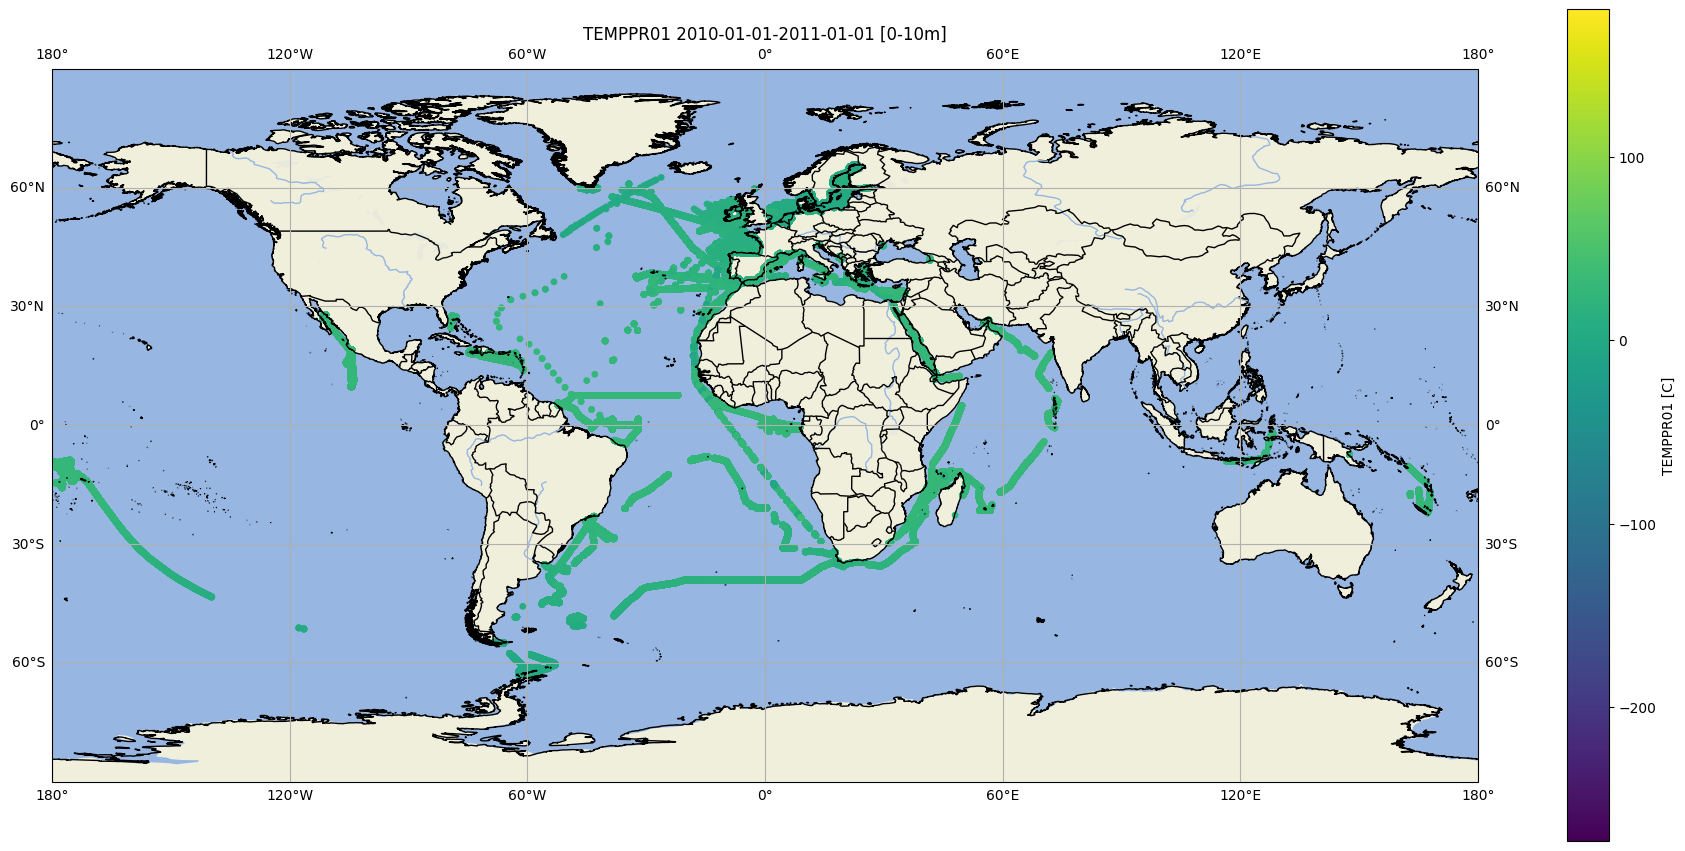

In [37]:
warnings.filterwarnings("ignore", category=UserWarning, module="cartopy")
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="viridis", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{parameter} [C]")

plt.title(f"{parameter} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()